# Checking if GPU is Connected

In [1]:
!nvidia-smi

Tue Dec  5 21:44:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Connecting drive to notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Checking current directory files

In [3]:
!ls

drive  sample_data


# Changing directory to project directory

In [4]:
%cd /content/drive/MyDrive/CSE805 Project/

/content/drive/MyDrive/CSE805 Project


# Checking current directory files

In [5]:
!ls

 best_model.h5		   'CSE805 Project Report.gdoc'   full_dataset.zip
 cnn_ela_model_weights.h5   CSE805_try1_12_4.ipynb	  Model_Acc_graph.png
 cnn_model_weights.h5	    CSE805_try1.ipynb		 'Note Nov 21, 2023.pdf'
 Confusion_Matrix.png	    CSE805_try2.ipynb		  Presentation_amar_yas.pptx
'CSE805 Project.gdoc'	    full_dataset		  temp.jpeg


# Unizzping dataset

In [6]:
# !unzip '/content/drive/MyDrive/CSE805 Project/full_dataset.zip' -d '/content/drive/MyDrive/CSE805 Project/'

# Importing all necessary libraries

In [7]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf

#additional (for visualization)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageChops, ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,  LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import  l2
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img

# Creating variable with filepath, image size and batch size

In [8]:
dataset_path = Path('/content/drive/MyDrive/CSE805 Project/full_dataset/')
output_directory = '/content/drive/MyDrive/CSE805 Project'
os.makedirs(output_directory, exist_ok=True)

img_shape = 256
batch_size=8

# Loading files from directory to a dataframe

In [9]:
file_names = []
labels = []

# Number of images to take from each folder
num_images_per_class = 1500

# Iterate through both real and fake folders
for label in ['Real', 'Fake']:
    label_path = dataset_path / label
    for file in sorted(label_path.glob('*.*'))[:num_images_per_class]:
        file_names.append(str(file))
        labels.append(label)

# Create a DataFrame
df = pd.DataFrame.from_dict({"images": file_names, "labels": labels})
print(df.shape)

(3000, 2)


#Checking the dataframe

In [10]:
df.head()

,images,labels
0,/content/drive/MyDrive/CSE805 Project/full_dat...,Real
1,/content/drive/MyDrive/CSE805 Project/full_dat...,Real
2,/content/drive/MyDrive/CSE805 Project/full_dat...,Real
3,/content/drive/MyDrive/CSE805 Project/full_dat...,Real
4,/content/drive/MyDrive/CSE805 Project/full_dat...,Real


In [11]:
df.tail()

,images,labels
2995,/content/drive/MyDrive/CSE805 Project/full_dat...,Fake
2996,/content/drive/MyDrive/CSE805 Project/full_dat...,Fake
2997,/content/drive/MyDrive/CSE805 Project/full_dat...,Fake
2998,/content/drive/MyDrive/CSE805 Project/full_dat...,Fake
2999,/content/drive/MyDrive/CSE805 Project/full_dat...,Fake


# Checking the labels present in dataframe

In [12]:
df['labels'].unique()

array(['Real', 'Fake'], dtype=object)

# Splitting the dataset to train, test and validation split in ratio 8:1:1

In [13]:
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test= train_test_split(df_temp, test_size=0.5, random_state=42)

# Loading split data and comverting it to input and labels for each set

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='images',
    y_col='labels',
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='images',
    y_col='labels',
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='images',
    y_col='labels',
    class_mode='binary',
)

Found 2400 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


#Checking the label association with class

In [15]:
unique_labels = df_train['labels'].unique()

for i, label in enumerate(unique_labels):
    print(f"Class {i}: Label {label}")

Class 0: Label Real
Class 1: Label Fake


In [16]:
def plot_history(model_history):
    fig,ax=plt.subplots(figsize=(15,5))
    training_acc= [acc*100 for acc in model_history.history['accuracy']]
    validation_acc = [acc*100 for acc in model_history.history['val_accuracy']]
    ax.plot(training_acc, label='Training Accuracy')
    ax.plot(validation_acc , label='Validation Accuracy')
    ax.legend()
    ax.grid(True)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Epochs')

# Function to plot images from generators

In [17]:
def plot_images(generator, num_images, title):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        batch = next(generator)
        image = batch[0][0]
        label = batch[1][0]
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'{title} {i}, Label: {label}', pad=10)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.8)
    plt.show()

# Plotting image with labels from train and validation set

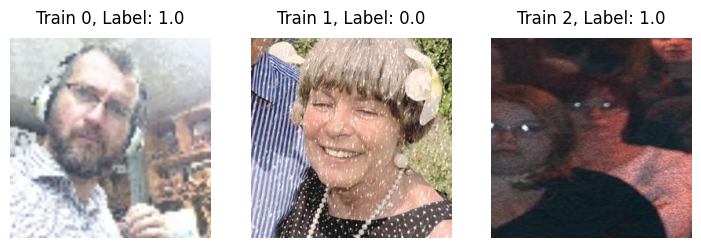

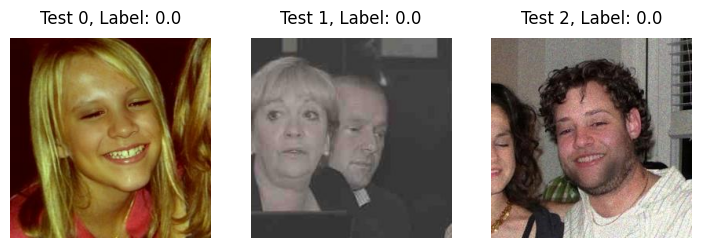

In [18]:
# Plot training images
plot_images(train_generator, num_images=3, title='Train')

# Plot test images
plot_images(validation_generator, num_images=3, title='Test')
unique_labels = df_train['labels'].unique()

# 0= Fake
# 1= Real

# Creating CNN Model

In [19]:
detector1 =models.Sequential([
    layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), input_shape=(img_shape, img_shape, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.9),
    layers.Dense(1,activation='sigmoid')
])

# Compiling model

In [20]:
detector1.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])

# Defining early stopping criteria

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               mode='min',
                               restore_best_weights=True)

# Defining path and name of best weights of the model

In [22]:
checkpoint1 = ModelCheckpoint(os.path.join(output_directory, "cnn_model_weights.h5"),
                              save_best_only=True,
                              monitor="val_accuracy",
                              mode="min")

# Training the model

In [23]:
history1 =detector1.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint1, early_stopping]
)

Epoch 1/100
75/75 [==============================] - 477s 6s/step - loss: 1.8344 - accuracy: 0.5242 - val_loss: 0.9160 - val_accuracy: 0.5333
Epoch 2/100
75/75 [==============================] - 8s 102ms/step - loss: 0.9582 - accuracy: 0.5612 - val_loss: 0.8912 - val_accuracy: 0.5433
Epoch 3/100
75/75 [==============================] - 7s 92ms/step - loss: 0.7515 - accuracy: 0.5925 - val_loss: 0.7972 - val_accuracy: 0.5633
Epoch 4/100
75/75 [==============================] - 7s 92ms/step - loss: 0.6901 - accuracy: 0.6258 - val_loss: 0.7110 - val_accuracy: 0.5833
Epoch 5/100
75/75 [==============================] - 7s 91ms/step - loss: 0.6630 - accuracy: 0.6442 - val_loss: 0.6677 - val_accuracy: 0.5900
Epoch 6/100
75/75 [==============================] - 7s 91ms/step - loss: 0.6269 - accuracy: 0.6633 - val_loss: 0.6397 - val_accuracy: 0.6100
Epoch 7/100
75/75 [==============================] - 7s 91ms/step - loss: 0.6331 - accuracy: 0.6654 - val_loss: 0.6445 - val_accuracy: 0.6067
Epoch

# Plotting model history

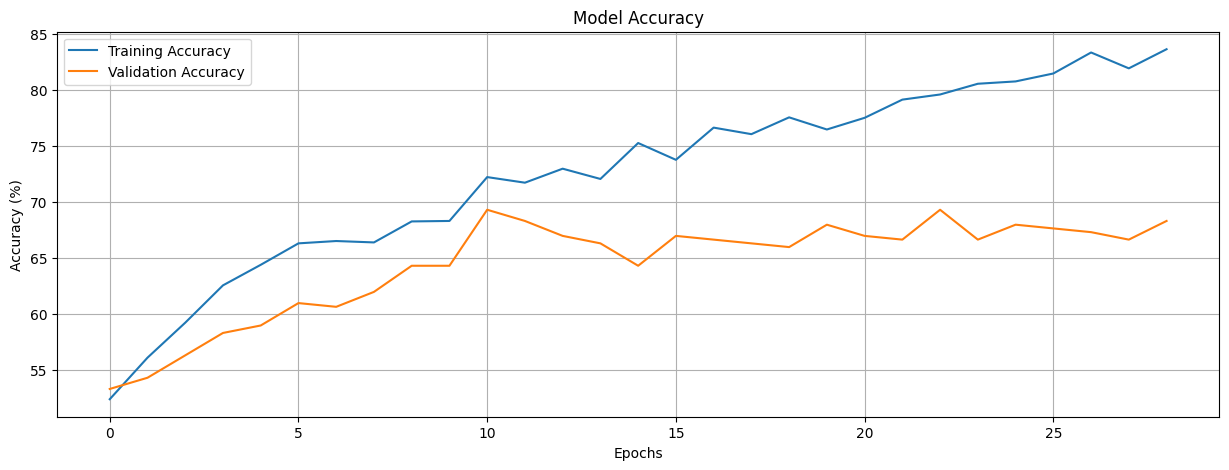

In [24]:
plot_history(history1)

# Evaluating the model

In [25]:
train_evaluation = detector1.evaluate(train_generator)
test_evaluation = detector1.evaluate(test_generator)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 49s 5s/step - loss: 0.6341 - accuracy: 0.6700
Training Evaluation:
Loss: 0.2260228544473648
Accuracy: 0.9641666412353516

Test Evaluation:
Loss: 0.6341049075126648
Accuracy: 0.6700000166893005


# Using model prediction on unseen test set to check the classification report and confusion matrix

10/10 [==============================] - 1s 75ms/step
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       146
           1       0.53      0.58      0.55       154

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300



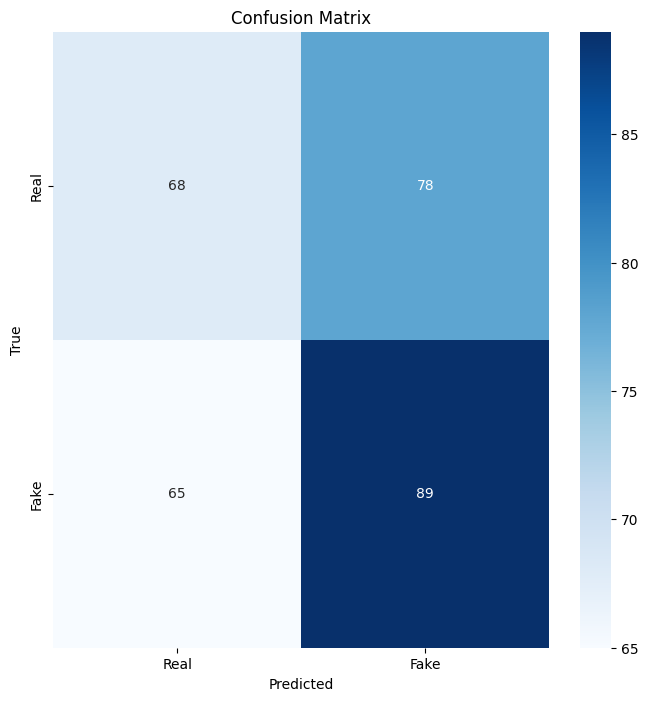

In [26]:
class_names = ["Real", "Fake"]
y_true = test_generator.classes
y_pred = detector1.predict(test_generator)
y_pred = np.where(y_pred > 0.48, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model with error-level analysis

# ELA function

In [27]:
def error_level_analysis(img_path):

    og_img = Image.open(img_path).convert('RGB')
    act_img = og_img
    temp_img_path = "temp.jpeg"
    og_img.save(temp_img_path, quality=95)

    temp_img = Image.open(temp_img_path)
    ela_img = ImageChops.difference(og_img, temp_img)

    extrema = ela_img.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)

    return act_img, ela_img

# Processing image to ELA images and saving to variable

In [28]:
def process_images(data_path, label, num_images=1500):
    act_images=[]
    images = []
    labels = []

    for filename in os.listdir(data_path)[:num_images]:
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_path, filename)
            act_img, ela_img = error_level_analysis(img_path)
            act_images.append(act_img)
            images.append(ela_img)
            labels.append(label)

    return act_images, images, labels

act_real_images, real_images, real_labels = process_images('/content/drive/MyDrive/CSE805 Project/full_dataset/Real', label=0)
act_fake_images, fake_images, fake_labels = process_images('/content/drive/MyDrive/CSE805 Project/full_dataset/Fake', label=1)

# Storing ELA images into dataframe

In [29]:
real_df = pd.DataFrame({'ogimages': act_real_images, 'images': real_images, 'labels': real_labels})
fake_df = pd.DataFrame({'ogimages': act_fake_images, 'images': fake_images, 'labels': fake_labels})
df = pd.concat([real_df, fake_df], ignore_index=True)

# Splitting the dataset to train, test and validation split in ratio 8:1:1

In [30]:
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Converting split dataset to image array

In [31]:
train_images = [np.array(img) for img in train_df['images']]
test_images = [np.array(img) for img in test_df['images']]
val_images = [np.array(img) for img in val_df['images']]



X_train = np.array(train_images)
X_test = np.array(test_images)
X_val = np.array(val_images)

X_train_og = [np.array(img) for img in train_df['ogimages']]
X_test_og = [np.array(img) for img in test_df['ogimages']]
X_val_og = [np.array(img) for img in val_df['ogimages']]

y_train = train_df['labels'].values
y_test = test_df['labels'].values
y_val = val_df['labels'].values


# Plotting actual and ELA images along with the label

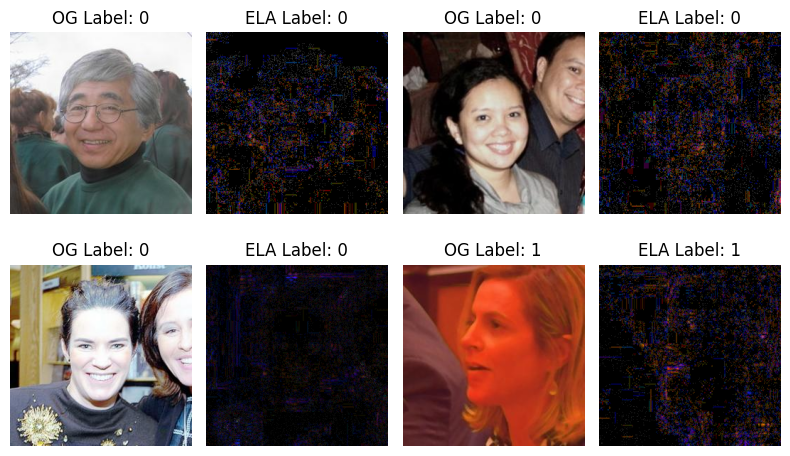

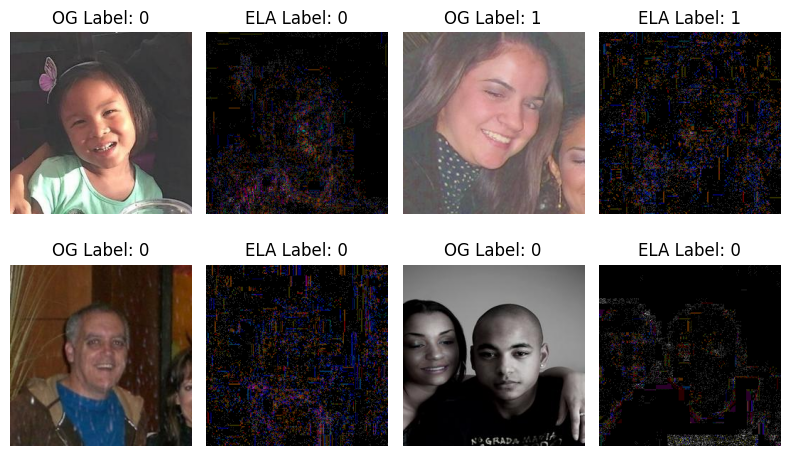

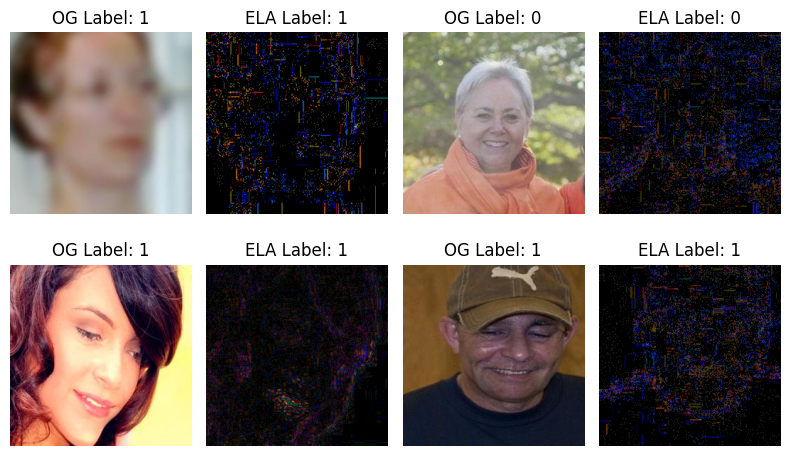

In [32]:
def show_images(ela,og,y, num_images=4):
    plt.figure(figsize=(2 * num_images, 5))

    for i in range(num_images):
        # Display the original image
        plt.subplot(2, num_images, 2 * i + 1)
        plt.imshow(og[i])
        plt.title(f'OG Label: {y[i]}')
        plt.axis('off')

        # Display the ELA image
        plt.subplot(2, num_images, 2 * i + 2)
        plt.imshow(ela[i])
        plt.title(f'ELA Label: {y[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(X_train, X_train_og, y_train)

show_images(X_test, X_test_og, y_test)

show_images(X_val, X_val_og, y_val)


# Creaing CNN model, training it and making predictions to check classification report and confusion matrix

In [33]:
detector2 =models.Sequential([

    layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), input_shape=(img_shape, img_shape, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.9),
    layers.Dense(1,activation='sigmoid')

])

In [34]:
detector2.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
detector2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 127, 127, 64)      256       
 chNormalization)                                                
                                                      

In [36]:
checkpoint2 = ModelCheckpoint(os.path.join(output_directory, "cnn_ela_model_weights.h5"),
                              save_best_only=True,
                              monitor="val_accuracy",
                              mode="min")

In [37]:
history2 = detector2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint2])

Epoch 1/100
75/75 [==============================] - 12s 135ms/step - loss: 1.5876 - accuracy: 0.4963 - val_loss: 0.6879 - val_accuracy: 0.5600
Epoch 2/100
75/75 [==============================] - 3s 34ms/step - loss: 0.7245 - accuracy: 0.5496 - val_loss: 0.6838 - val_accuracy: 0.5833
Epoch 3/100
75/75 [==============================] - 3s 33ms/step - loss: 0.7088 - accuracy: 0.5542 - val_loss: 0.6757 - val_accuracy: 0.5733
Epoch 4/100
75/75 [==============================] - 2s 33ms/step - loss: 0.6863 - accuracy: 0.5821 - val_loss: 0.6790 - val_accuracy: 0.5833
Epoch 5/100
75/75 [==============================] - 3s 33ms/step - loss: 0.6894 - accuracy: 0.5721 - val_loss: 0.6783 - val_accuracy: 0.6100
Epoch 6/100
75/75 [==============================] - 3s 34ms/step - loss: 0.6730 - accuracy: 0.5725 - val_loss: 0.6681 - val_accuracy: 0.6100
Epoch 7/100
75/75 [==============================] - 3s 34ms/step - loss: 0.6571 - accuracy: 0.5954 - val_loss: 0.6625 - val_accuracy: 0.6300
Epoc

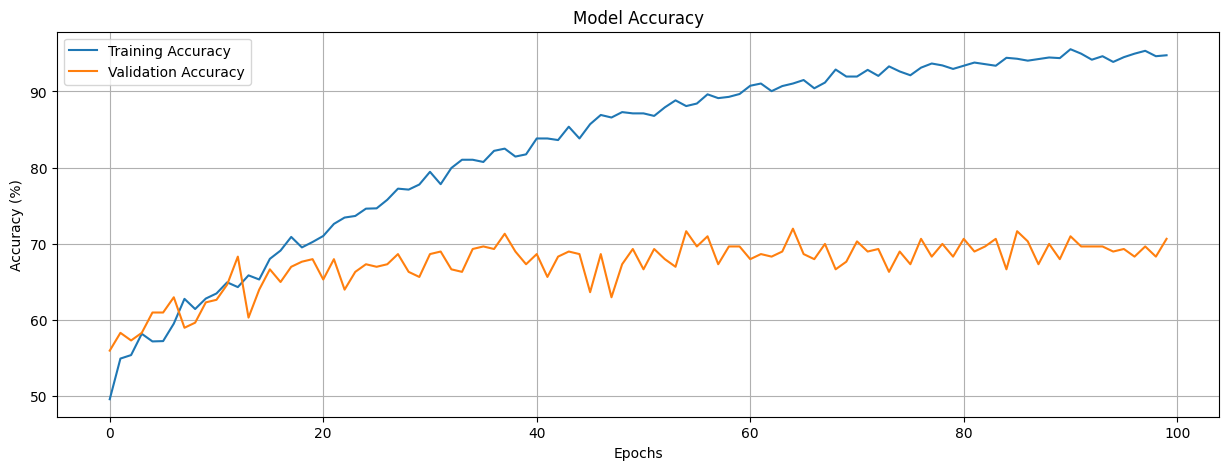

In [38]:
plot_history(history2)

In [39]:
train_evaluation = detector2.evaluate(X_train, y_train)
test_evaluation = detector2.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 0s 10ms/step - loss: 0.6078 - accuracy: 0.7267
Training Evaluation:
Loss: 0.012114590033888817
Accuracy: 1.0

Test Evaluation:
Loss: 0.6077746748924255
Accuracy: 0.7266666889190674


10/10 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       159
           1       0.68      0.78      0.73       141

    accuracy                           0.72       300
   macro avg       0.73      0.73      0.72       300
weighted avg       0.73      0.72      0.72       300



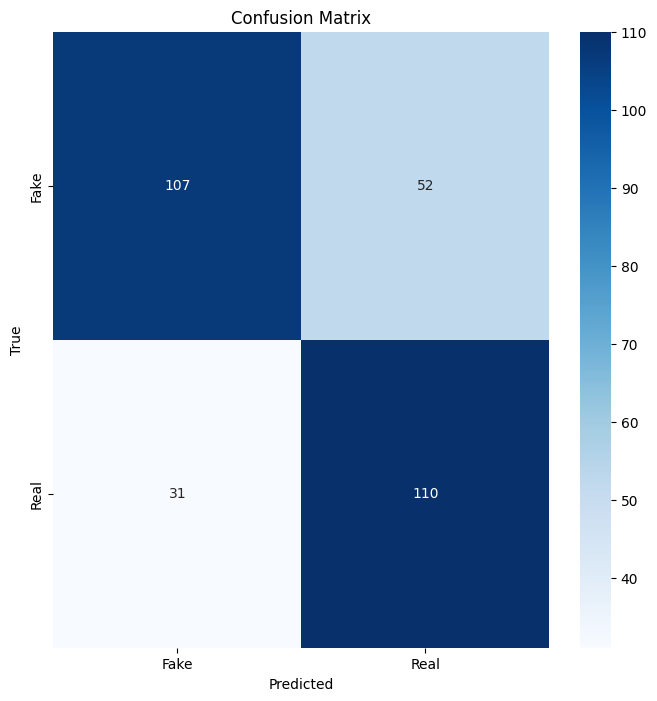

In [40]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector2.predict(X_test)
y_pred = np.where(y_pred > 0.45, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Transfer Learning models

# Loading the feature extractor models and ensuring the weights do not get updated

In [41]:
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
base_model3 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
base_model4 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
base_model5 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))

base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False
base_model4.trainable = False
base_model5.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


# Creaing CNN model, training it and making predictions to check classification report and confusion matrix

In [42]:
detector3=models.Sequential([
    base_model1,

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(1,activation='sigmoid')
])

In [43]:
detector4=models.Sequential([
    base_model2,

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(1,activation='sigmoid')
])

In [44]:
detector5=models.Sequential([
    base_model3,

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(1,activation='sigmoid')
])

In [45]:
detector6=models.Sequential([
    base_model4,

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(1,activation='sigmoid')
])

In [46]:
detector7=models.Sequential([
    base_model5,

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same",kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(1,activation='sigmoid')
])

In [47]:
detector3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
detector4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
detector5.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
detector6.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
detector7.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
history3 = detector3.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 8s 66ms/step - loss: 1.3270 - accuracy: 0.5042 - val_loss: 0.7828 - val_accuracy: 0.5267
Epoch 2/100
75/75 [==============================] - 4s 52ms/step - loss: 1.0066 - accuracy: 0.5446 - val_loss: 0.7400 - val_accuracy: 0.5333
Epoch 3/100
75/75 [==============================] - 4s 52ms/step - loss: 0.8217 - accuracy: 0.5850 - val_loss: 0.7064 - val_accuracy: 0.5333
Epoch 4/100
75/75 [==============================] - 4s 52ms/step - loss: 0.6841 - accuracy: 0.6346 - val_loss: 0.7050 - val_accuracy: 0.5567
Epoch 5/100
75/75 [==============================] - 4s 52ms/step - loss: 0.6363 - accuracy: 0.6629 - val_loss: 0.7023 - val_accuracy: 0.5700
Epoch 6/100
75/75 [==============================] - 4s 52ms/step - loss: 0.6074 - accuracy: 0.6879 - val_loss: 0.6889 - val_accuracy: 0.5767
Epoch 7/100
75/75 [==============================] - 4s 52ms/step - loss: 0.5708 - accuracy: 0.7075 - val_loss: 0.6967 - val_accuracy: 0.5900
Epoch 

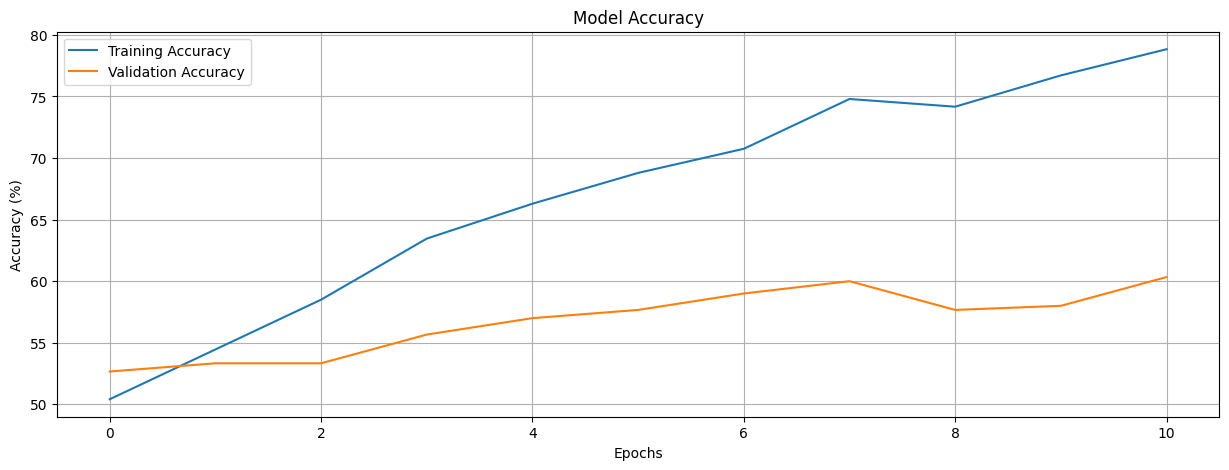

In [53]:
plot_history(history3)

In [54]:
history4 = detector4.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 7s 70ms/step - loss: 1.3956 - accuracy: 0.5271 - val_loss: 0.7919 - val_accuracy: 0.5167
Epoch 2/100
75/75 [==============================] - 5s 64ms/step - loss: 1.0305 - accuracy: 0.5608 - val_loss: 0.7351 - val_accuracy: 0.5433
Epoch 3/100
75/75 [==============================] - 5s 63ms/step - loss: 0.8699 - accuracy: 0.5638 - val_loss: 0.7062 - val_accuracy: 0.5633
Epoch 4/100
75/75 [==============================] - 5s 63ms/step - loss: 0.7560 - accuracy: 0.6108 - val_loss: 0.6967 - val_accuracy: 0.5700
Epoch 5/100
75/75 [==============================] - 5s 64ms/step - loss: 0.6731 - accuracy: 0.6508 - val_loss: 0.6763 - val_accuracy: 0.5900
Epoch 6/100
75/75 [==============================] - 5s 63ms/step - loss: 0.6284 - accuracy: 0.6712 - val_loss: 0.6790 - val_accuracy: 0.5800
Epoch 7/100
75/75 [==============================] - 5s 63ms/step - loss: 0.6074 - accuracy: 0.6883 - val_loss: 0.6713 - val_accuracy: 0.6100
Epoch 

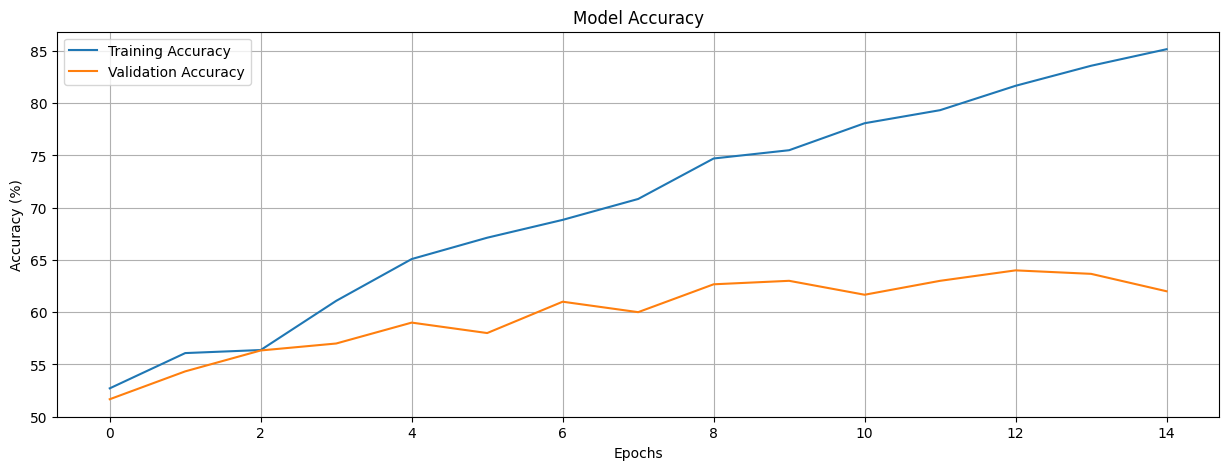

In [55]:
plot_history(history4)

In [56]:
history5 = detector5.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 10s 69ms/step - loss: 1.4073 - accuracy: 0.5229 - val_loss: 0.7091 - val_accuracy: 0.6133
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.9240 - accuracy: 0.5746 - val_loss: 0.6825 - val_accuracy: 0.6133
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 0.7491 - accuracy: 0.6258 - val_loss: 0.6792 - val_accuracy: 0.6267
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.6463 - accuracy: 0.6642 - val_loss: 0.6567 - val_accuracy: 0.6433
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 0.5990 - accuracy: 0.6854 - val_loss: 0.6338 - val_accuracy: 0.6600
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 0.5493 - accuracy: 0.7113 - val_loss: 0.6429 - val_accuracy: 0.6667
Epoch 7/100
75/75 [==============================] - 3s 45ms/step - loss: 0.4984 - accuracy: 0.7604 - val_loss: 0.7051 - val_accuracy: 0.6067
Epoch

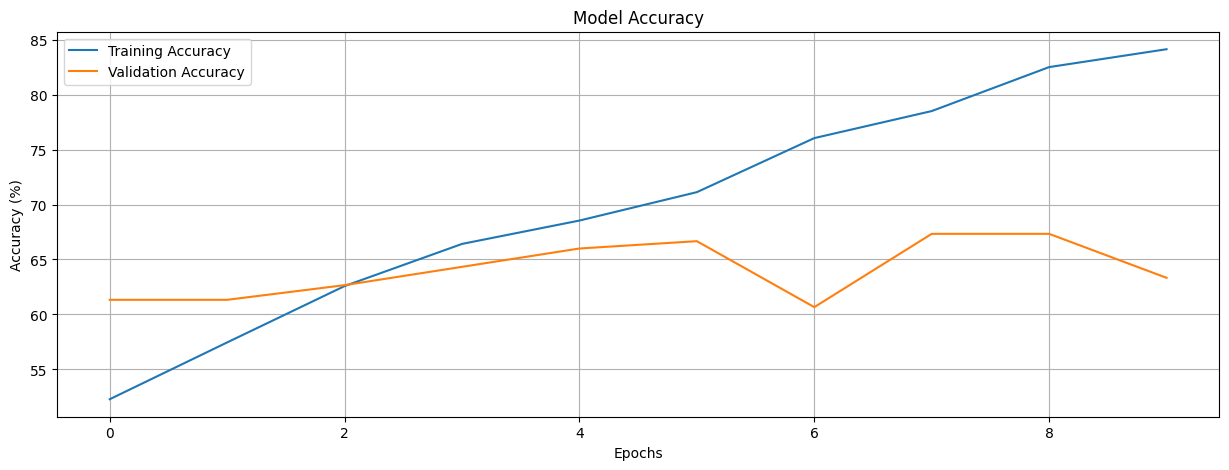

In [57]:
plot_history(history5)

In [58]:
history6 = detector6.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 12s 78ms/step - loss: 1.2296 - accuracy: 0.5008 - val_loss: 0.7576 - val_accuracy: 0.5433
Epoch 2/100
75/75 [==============================] - 3s 41ms/step - loss: 0.9707 - accuracy: 0.5450 - val_loss: 0.7258 - val_accuracy: 0.5367
Epoch 3/100
75/75 [==============================] - 3s 42ms/step - loss: 0.8319 - accuracy: 0.5512 - val_loss: 0.7036 - val_accuracy: 0.5633
Epoch 4/100
75/75 [==============================] - 3s 39ms/step - loss: 0.7705 - accuracy: 0.5783 - val_loss: 0.7050 - val_accuracy: 0.5467
Epoch 5/100
75/75 [==============================] - 3s 41ms/step - loss: 0.7282 - accuracy: 0.6054 - val_loss: 0.6965 - val_accuracy: 0.5600
Epoch 6/100
75/75 [==============================] - 3s 41ms/step - loss: 0.6583 - accuracy: 0.6425 - val_loss: 0.6918 - val_accuracy: 0.5700
Epoch 7/100
75/75 [==============================] - 3s 40ms/step - loss: 0.6286 - accuracy: 0.6542 - val_loss: 0.6948 - val_accuracy: 0.5800
Epoch

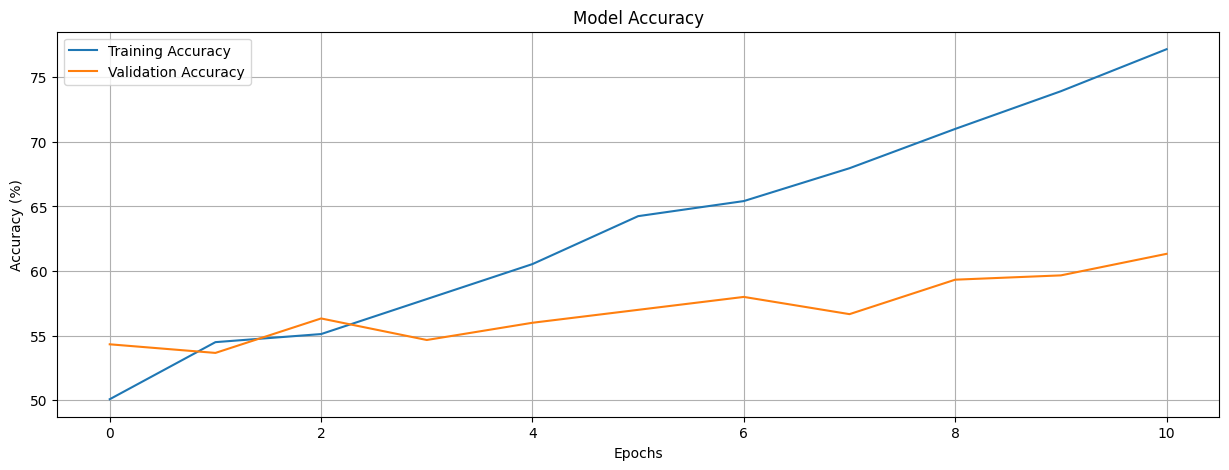

In [59]:
plot_history(history6)

In [60]:
history7 = detector7.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 13s 70ms/step - loss: 1.2217 - accuracy: 0.5329 - val_loss: 0.6847 - val_accuracy: 0.5433
Epoch 2/100
75/75 [==============================] - 3s 35ms/step - loss: 0.9589 - accuracy: 0.5592 - val_loss: 0.6985 - val_accuracy: 0.5900
Epoch 3/100
75/75 [==============================] - 3s 35ms/step - loss: 0.7800 - accuracy: 0.6004 - val_loss: 0.6990 - val_accuracy: 0.5733
Epoch 4/100
75/75 [==============================] - 3s 35ms/step - loss: 0.7049 - accuracy: 0.6333 - val_loss: 0.6955 - val_accuracy: 0.5633
Epoch 5/100
75/75 [==============================] - 3s 35ms/step - loss: 0.6457 - accuracy: 0.6587 - val_loss: 0.6881 - val_accuracy: 0.5733
Epoch 6/100
75/75 [==============================] - 3s 36ms/step - loss: 0.5915 - accuracy: 0.6925 - val_loss: 0.6676 - val_accuracy: 0.6167
Epoch 7/100
75/75 [==============================] - 3s 35ms/step - loss: 0.6015 - accuracy: 0.7004 - val_loss: 0.6852 - val_accuracy: 0.5967
Epoch

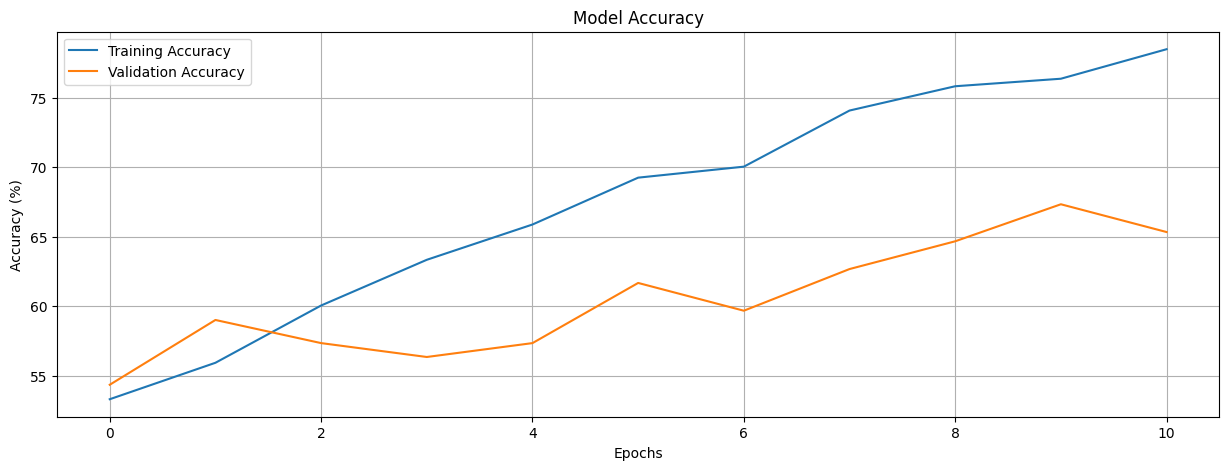

In [61]:
plot_history(history7)

In [62]:
train_evaluation = detector3.evaluate(X_train, y_train)
test_evaluation = detector3.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 0s 44ms/step - loss: 0.6783 - accuracy: 0.5833
Training Evaluation:
Loss: 0.4465027451515198
Accuracy: 0.8570833206176758

Test Evaluation:
Loss: 0.6782524585723877
Accuracy: 0.5833333134651184


10/10 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       159
           1       0.52      0.77      0.62       141

    accuracy                           0.56       300
   macro avg       0.58      0.57      0.54       300
weighted avg       0.58      0.56      0.54       300



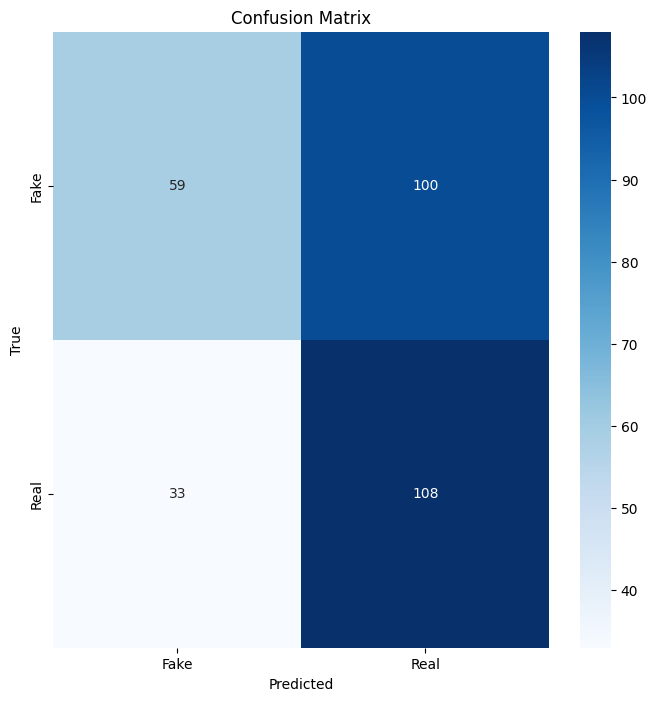

In [63]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector3.predict(X_test)
y_pred = np.where(y_pred > 0.45, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [64]:
train_evaluation = detector4.evaluate(X_train, y_train)
test_evaluation = detector4.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 1s 52ms/step - loss: 0.6862 - accuracy: 0.5800
Training Evaluation:
Loss: 0.35227036476135254
Accuracy: 0.9304166436195374

Test Evaluation:
Loss: 0.6861814856529236
Accuracy: 0.5799999833106995


10/10 [==============================] - 1s 52ms/step
              precision    recall  f1-score   support

           0       0.74      0.35      0.48       159
           1       0.54      0.86      0.66       141

    accuracy                           0.59       300
   macro avg       0.64      0.61      0.57       300
weighted avg       0.64      0.59      0.56       300



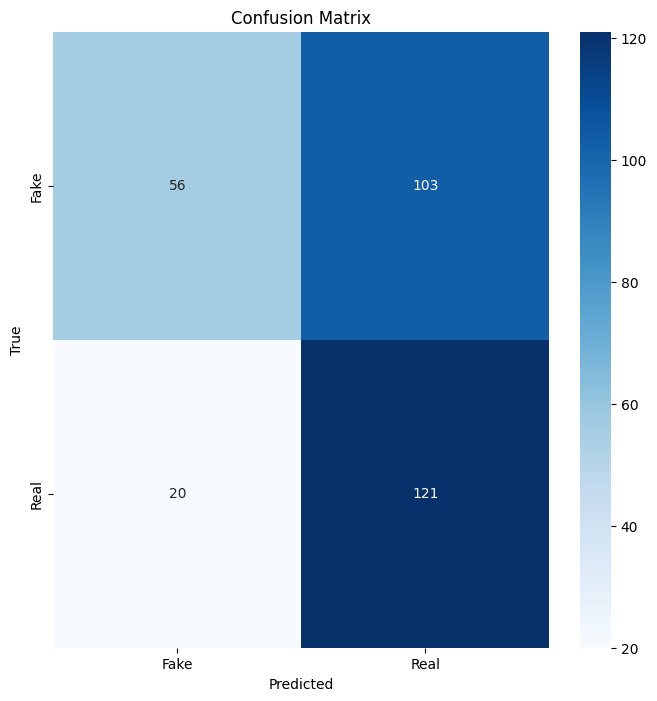

In [65]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector4.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [66]:
train_evaluation = detector5.evaluate(X_train, y_train)
test_evaluation = detector5.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 0s 39ms/step - loss: 0.6162 - accuracy: 0.6400
Training Evaluation:
Loss: 0.4357699453830719
Accuracy: 0.8454166650772095

Test Evaluation:
Loss: 0.6161527633666992
Accuracy: 0.6399999856948853


10/10 [==============================] - 1s 37ms/step
              precision    recall  f1-score   support

           0       0.67      0.44      0.53       159
           1       0.55      0.76      0.64       141

    accuracy                           0.59       300
   macro avg       0.61      0.60      0.58       300
weighted avg       0.61      0.59      0.58       300



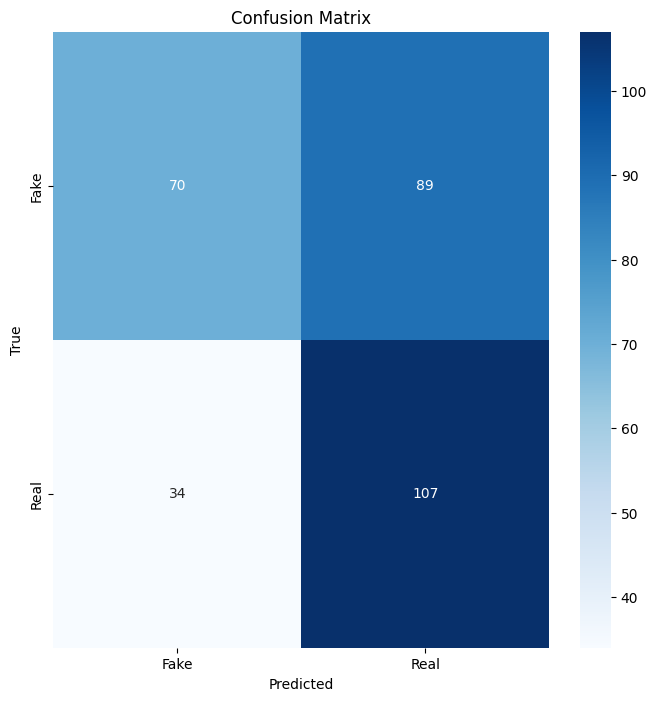

In [67]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector5.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
train_evaluation = detector6.evaluate(X_train, y_train)
test_evaluation = detector6.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 0s 34ms/step - loss: 0.6746 - accuracy: 0.6200
Training Evaluation:
Loss: 0.5361354351043701
Accuracy: 0.747083306312561

Test Evaluation:
Loss: 0.6746427416801453
Accuracy: 0.6200000047683716


10/10 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

           0       0.68      0.45      0.54       159
           1       0.55      0.76      0.64       141

    accuracy                           0.60       300
   macro avg       0.62      0.61      0.59       300
weighted avg       0.62      0.60      0.59       300



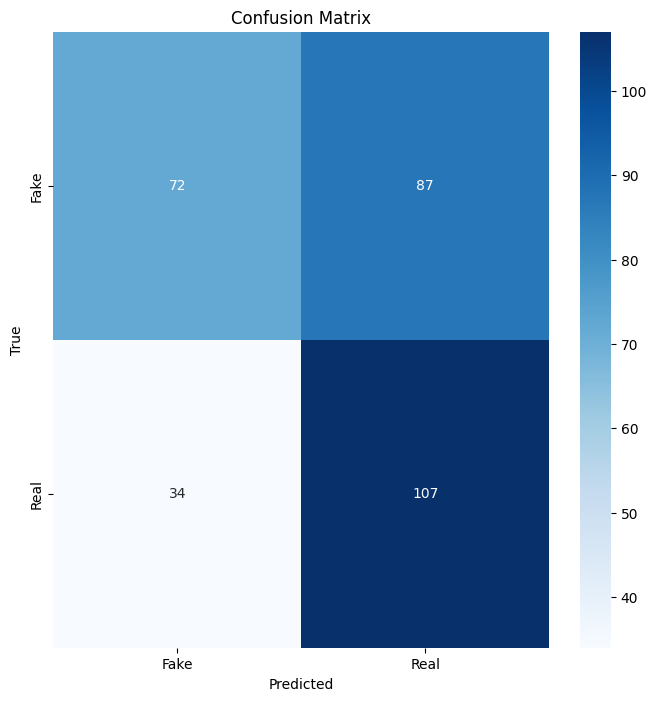

In [69]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector6.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [70]:
train_evaluation = detector7.evaluate(X_train, y_train)
test_evaluation = detector7.evaluate(X_test, y_test)

print("Training Evaluation:")
print("Loss:", train_evaluation[0])
print("Accuracy:", train_evaluation[1])

print("\nTest Evaluation:")
print("Loss:", test_evaluation[0])
print("Accuracy:", test_evaluation[1])

10/10 [==============================] - 0s 29ms/step - loss: 0.6137 - accuracy: 0.6700
Training Evaluation:
Loss: 0.4246635138988495
Accuracy: 0.8462499976158142

Test Evaluation:
Loss: 0.6136888861656189
Accuracy: 0.6700000166893005


10/10 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.81      0.38      0.52       159
           1       0.56      0.90      0.69       141

    accuracy                           0.62       300
   macro avg       0.69      0.64      0.60       300
weighted avg       0.69      0.62      0.60       300



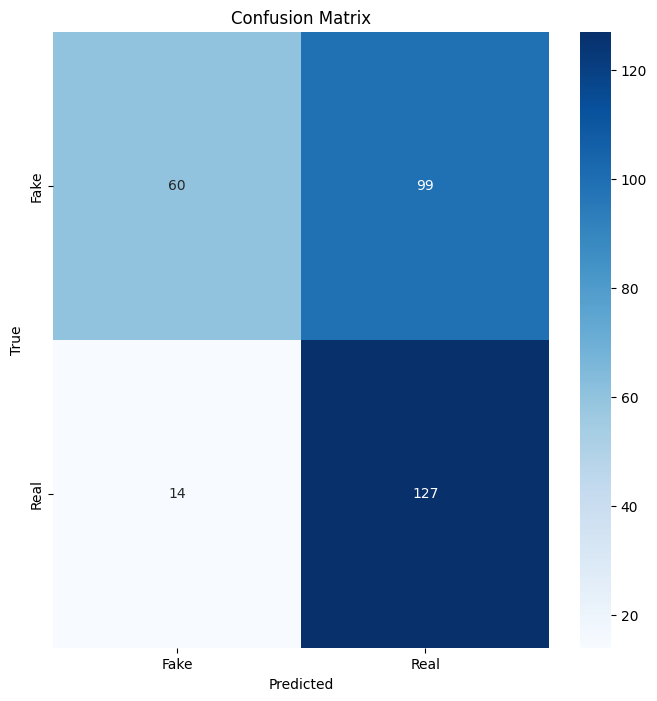

In [71]:
class_names = ['Fake','Real']
y_true = y_test
y_pred = detector7.predict(X_test)
y_pred = np.where(y_pred > 0.4, 1, 0)
y_pred = np.squeeze(y_pred)
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()